<a href="https://colab.research.google.com/github/liuyao12/Ranger-Mish-ImageWoof-5/blob/master/Woof_128_new_ConvTwist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet with a Twist

> ConvTwist + Ranger + Mish + MaxBlurPool + restrick

# setup and imports

In [0]:
# pip install git+https://github.com/kornia/kornia

In [1]:
pip install git+https://github.com/ayasyrev/model_constructor

  Cloning https://github.com/ayasyrev/model_constructor to /tmp/pip-req-build-hnby3m44
  Running command git clone -q https://github.com/ayasyrev/model_constructor /tmp/pip-req-build-hnby3m44
  Created wheel for model-constructor: filename=model_constructor-0.1.1-cp36-none-any.whl size=21649 sha256=40000038103457641e6c4a90772b923bac2e18b3dbe7271dd4c5844c3b0bba37
  Stored in directory: /tmp/pip-ephem-wheel-cache-hb6xb8rn/wheels/5b/92/65/8093a307d5802f41f4a8776b40bc12b558e75a2a906ae8b683
Successfully built model-constructor


In [2]:
pip install git+https://github.com/ayasyrev/imagenette_experiments

  Cloning https://github.com/ayasyrev/imagenette_experiments to /tmp/pip-req-build-9kd67t15
  Running command git clone -q https://github.com/ayasyrev/imagenette_experiments /tmp/pip-req-build-9kd67t15
     |████████████████████████████████| 163kB 6.0MB/s 
  Created wheel for imagenette-experiments: filename=imagenette_experiments-0.0.1-cp36-none-any.whl size=12379 sha256=76faa4f997fbc692e43e8895be29baa93014db1bbcd0f24897962bf0b1c04f2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-du2e9d7b/wheels/af/99/98/2212941f45a18bf6d191f56c39e3569138414560c76defc0d4
Successfully built imagenette-experiments


In [0]:
from imagenette_experiments.train_utils import *

In [0]:
from kornia.contrib import MaxBlurPool2d

In [0]:
from fastai.basic_train import *
from fastai.vision import *
# from fastai.script import *
from model_constructor.net import Net, act_fn
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# Twist

In [0]:
class ConvTwist(nn.Module):  # replacing 3x3 Conv2d
    def __init__(self, ni, nf, stride=1, groups=1, iters=1, init_max=0.7):
        super(ConvTwist, self).__init__()
        self.twist = False
        self.same = ni==nf and stride==1
        if not (ni%groups==0 and nf%groups==0): groups = 1
        elif ni%64==0: groups = ni//8
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
        if self.twist:
            # self.conv_x = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
            # self.conv_y = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
            std = self.conv.weight.std().item()
            self.coeff_Ax = nn.Parameter(torch.empty((nf,ni//groups)).normal_(0, std), requires_grad=True)
            self.coeff_Ay = nn.Parameter(torch.empty((nf,ni//groups)).normal_(0, std), requires_grad=True)
            # self.coeff_Bx = nn.Parameter(torch.zeros((nf,ni)).normal_(0, std), requires_grad=True)
            # self.coeff_By = nn.Parameter(torch.zeros((nf,ni)).normal_(0, std), requires_grad=True)
            # self.center_x = nn.Parameter(torch.Tensor(nf), requires_grad=True)
            # self.center_y = nn.Parameter(torch.Tensor(nf), requires_grad=True)
            # self.center_x.data.uniform_(-init_max, init_max)
            # self.center_y.data.uniform_(-init_max, init_max)
        self.iters = iters
        self.stride = stride
        self.groups = groups

    # def init_coeff(self):
    #     self.coeff_Bx.data = self.coeff_Ay
    #     self.coeff_By.data = -self.coeff_Ax

    def kernel(self, coeff_x, coeff_y):
        D_x = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).to(coeff_x.device)
        D_y = torch.Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(coeff_x.device)
        return coeff_x[:,:,None,None] * D_x + coeff_y[:,:,None,None] * D_y

    def full_kernel(self, kernel): # permuting the groups
        if self.groups==1: return kernel
        n = self.groups
        a,b,_,_ = kernel.size()
        a = a//n
        KK = torch.zeros((a*n,b*n,3,3)).to(kernel.device)
        KK[:a,-b:] = kernel[:a]
        for i in range(n):
            if i%4==0:
                KK[a*i:a*(i+1),b*(i+3):b*(i+4)] = kernel[a*i:a*(i+1)]
            else:
                KK[a*i:a*(i+1),b*(i-1):b*i] = kernel[a*i:a*(i+1)]
        return KK

    def _conv(self, inpt, kernel=None):
        permute = True
        if kernel is None:
            kernel = self.conv.weight
        if self.groups==1 or permute==False:
            return F.conv2d(inpt, kernel, padding=1, stride=self.stride, groups=self.groups)
        else:
            return F.conv2d(inpt, self.full_kernel(kernel), padding=1, stride=self.stride, groups=1)

    def symmetrize(self, conv_wt):
        # conv_wt.data = (conv_wt - conv_wt.flip(2).flip(3)) / 2
        if self.same:
            n = conv_wt.size()[1]
            for i in range(self.groups):
                conv_wt.data[n*i:n*(i+1)] = (conv_wt[n*i:n*(i+1)] + torch.transpose(conv_wt[n*i:n*(i+1)],0,1)) / 2

    def forward(self, inpt):
        out = self._conv(inpt)
        if self.twist is False:
            return out
        _,_,h,w = out.size()
        XX = torch.from_numpy(np.indices((1,1,h,w))[3]*2/w-1).type(out.dtype).to(out.device) 
        YY = torch.from_numpy(np.indices((1,1,h,w))[2]*2/h-1).type(out.dtype).to(out.device)
        # self.symmetrize(self.conv_x.weight)
        # self.symmetrize(self.conv_y.weight)
        # kernel_x = self.conv_x.weight
        # kernel_y = self.conv_y.weight
        # self.symmetrize(self.coeff_Ax)
        # self.symmetrize(self.coeff_Ay)
        kernel_x = self.kernel(self.coeff_Ax, self.coeff_Ay)
        self.symmetrize(kernel_x)
        # self.symmetrize(kernel_y)
        kernel_y = kernel_x.transpose(2,3).flip(3)  # make conv_y a 90 degree rotation of conv_x
        # kernel_y = self.kernel(self.coeff_Bx, self.coeff_By)
        out = out + XX * self._conv(inpt, kernel_x) + YY * self._conv(inpt, kernel_y)
        # out = out + (XX-self.center_x.view(-1,1,1)) * self.conv_x(inpt) + (YY-self.center_y.view(-1,1,1)) * self.conv_y(inpt)
        if self.same and self.iters>1:
            out = inpt + out / self.iters
            for _ in range(self.iters-1):
                out = out + (self._conv(out) + XX * self._conv(out, kernel_x) + YY * self._conv(out, kernel_y)) / self.iters
            out = out - inpt
        return out

In [50]:
D_x = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]])/4
F.conv2d(D_x.view(1,1,3,3), D_x.view(1,1,3,3), padding=2)

tensor([[[[-0.0625,  0.0000,  0.1250,  0.0000, -0.0625],
          [-0.2500,  0.0000,  0.5000,  0.0000, -0.2500],
          [-0.3750,  0.0000,  0.7500,  0.0000, -0.3750],
          [-0.2500,  0.0000,  0.5000,  0.0000, -0.2500],
          [-0.0625,  0.0000,  0.1250,  0.0000, -0.0625]]]])

# ResBlock

In [0]:
class NewLayer(nn.Sequential):
    """Basic conv layers block"""
    def __init__(self, ni, nf, ks=3, stride=1,
            act=True,  act_fn=nn.ReLU(inplace=True),
            bn_layer=True, bn_1st=True, zero_bn=False,
            padding=None, bias=False, groups=1, **kwargs):

        if padding==None: padding = ks//2
        if ks==3:  layers = [('ConvTwist', ConvTwist(ni, nf, stride=stride))]
        else: layers = [('Conv{}x{}'.format(ks,ks), 
                  nn.Conv2d(ni, nf, ks, stride=stride, padding=padding, bias=bias, groups=groups))]

        act_bn = [('act_fn', act_fn)] if act else []
        if bn_layer:
            bn = nn.BatchNorm2d(nf)
            nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
            act_bn += [('bn', bn)]
        if bn_1st: act_bn.reverse()
        layers += act_bn
        super().__init__(OrderedDict(layers))

In [0]:
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1,
                 conv_layer=ConvLayer, act_fn=act_fn, bn_1st=True,
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False, sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        conv_layer = NewLayer
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ] if expansion == 1 else [
                   (f"conv_0", conv_layer(ni, nh, 1, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nh, 3, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_2", conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False, bn_1st=bn_1st)
        self.merge = act_fn

    def forward(self, x):
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

# Model Constructor

In [0]:
model = Net(c_out=10, layers=[3,4,6,3], expansion=4)
model.block = NewResBlock
# model.conv_layer = NewLayer # for the stem
pool = MaxBlurPool2d(3, True)
model.pool = pool
model.stem_pool = pool
model.stem_sizes = [3,32,64,64]
model.act_fn = Mish()
model.sa = True

# Runs and results



In [39]:
for _ in range(1):
    learn = get_learn(model=model, size=128, bs=32, mixup=0.4)
    learn.fit_fc(80, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)

data path   /root/.fastai/data/imagewoof2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.138296,1.912720,0.364978,0.847289,02:02
1,1.964215,1.682430,0.480020,0.900738,02:02
2,1.827920,1.459167,0.591245,0.942734,02:01
3,1.743896,1.431228,0.604734,0.941970,02:01
4,1.654279,1.280349,0.687452,0.950624,02:01
5,1.601300,1.219149,0.705269,0.961822,02:00
6,1.545624,1.208093,0.708832,0.961313,01:59
7,1.507613,1.146444,0.731993,0.964113,02:00
8,1.462433,1.094124,0.756681,0.970221,02:03
9,1.426328,1.079307,0.763044,0.970730,02:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Buffered data was truncated after reaching the output size limit.

In [22]:
res = [0.754899, 0.751082, 0.755663, 0.748028, 0.749555]
sum(res) / 5

0.7518454

In [27]:
res = [0.757445, 0.748028, 0.768643, 0.757445, 0.754136]
sum(res) / 5

0.7571394

In [38]:
res = [0.758208, 0.754645, 0.756172, 0.757699, 0.765335]
sum(res) / 5

0.7584118

In [40]:
for i in range(80):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.3649783730506897
epoch 1 0.4800203740596771
epoch 2 0.5912445783615112
epoch 3 0.6047340035438538
epoch 4 0.6874522566795349
epoch 5 0.7052685022354126
epoch 6 0.708831787109375
epoch 7 0.7319929003715515
epoch 8 0.7566810846328735
epoch 9 0.7630440592765808
epoch 10 0.7864596843719482
epoch 11 0.7984219789505005
epoch 12 0.8065665364265442
epoch 13 0.7974039316177368
epoch 14 0.8096207976341248
epoch 15 0.7999491095542908
epoch 16 0.8114023804664612
epoch 17 0.8047849535942078
epoch 18 0.7966403961181641
epoch 19 0.828964114189148
epoch 20 0.8259099125862122
epoch 21 0.8248918056488037
epoch 22 0.8310002684593201
epoch 23 0.8299821615219116
epoch 24 0.8348180055618286
epoch 25 0.8259099125862122
epoch 26 0.8376176953315735
epoch 27 0.8411809802055359
epoch 28 0.8373631834983826
epoch 29 0.8378722071647644
epoch 30 0.8378722071647644
epoch 31 0.8434716463088989
epoch 32 0.8363451361656189
epoch 33 0.8340544700622559
epoch 34 0.8353270292282104
epoch 35 0.8429625630378723
epoc

In [23]:
for i in range(80):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.35607025027275085
epoch 1 0.4662764072418213
epoch 2 0.5454314351081848
epoch 3 0.601679801940918
epoch 4 0.6627640724182129
epoch 5 0.6864342093467712
epoch 6 0.7258844375610352
epoch 7 0.7520997524261475
epoch 8 0.7638075947761536
epoch 9 0.7737337946891785
epoch 10 0.7793331742286682
epoch 11 0.7778060436248779
epoch 12 0.7813693284988403
epoch 13 0.7979129552841187
epoch 14 0.8027487993240356
epoch 15 0.8083481788635254
epoch 16 0.8139475584030151
epoch 17 0.8164927363395691
epoch 18 0.8185288906097412
epoch 19 0.8343089818954468
epoch 20 0.8248918056488037
epoch 21 0.828964114189148
epoch 22 0.8304912447929382
epoch 23 0.8307457566261292
epoch 24 0.8373631834983826
epoch 25 0.8195469379425049
epoch 26 0.8279460668563843
epoch 27 0.8376176953315735
epoch 28 0.8439806699752808
epoch 29 0.8332909345626831
epoch 30 0.8411809802055359
epoch 31 0.8358361124992371
epoch 32 0.8282005786895752
epoch 33 0.8297276496887207
epoch 34 0.8475438952445984
epoch 35 0.8421990275382996
epo

In [31]:
for i in range(80):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.39857470989227295
epoch 1 0.4728938639163971
epoch 2 0.5808093547821045
epoch 3 0.6230593323707581
epoch 4 0.6877067685127258
epoch 5 0.7093408107757568
epoch 6 0.7437006831169128
epoch 7 0.7421735525131226
epoch 8 0.7686434388160706
epoch 9 0.7790786623954773
epoch 10 0.7788241505622864
epoch 11 0.7971494197845459
epoch 12 0.7961313128471375
epoch 13 0.7739883065223694
epoch 14 0.8009671568870544
epoch 15 0.8129295110702515
epoch 16 0.8030033111572266
epoch 17 0.8180198669433594
epoch 18 0.8129295110702515
epoch 19 0.8172562718391418
epoch 20 0.8292186260223389
epoch 21 0.828709602355957
epoch 22 0.819037914276123
epoch 23 0.8297276496887207
epoch 24 0.8279460668563843
epoch 25 0.8284550905227661
epoch 26 0.8404173851013184
epoch 27 0.8465258479118347
epoch 28 0.821583092212677
epoch 29 0.8343089818954468
epoch 30 0.8256554007530212
epoch 31 0.8388903141021729
epoch 32 0.8437261581420898
epoch 33 0.8404173851013184
epoch 34 0.8404173851013184
epoch 35 0.8399083614349365
epoc

In [0]:
for _ in range(1):
    learn = get_learn(model=model, size=128, bs=32, mixup=0.5)
    learn.fit_fc(80, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.174184,1.920759,0.357852,0.845508,01:35
1,1.997055,1.762287,0.441079,0.894375,01:35
2,1.895067,1.564714,0.525834,0.914228,01:36
3,1.794292,1.440246,0.610588,0.936371,01:36
4,1.712571,1.328491,0.659710,0.950878,01:36
5,1.668134,1.268177,0.670654,0.955714,01:37
6,1.628677,1.221262,0.701960,0.960041,01:36
7,1.578143,1.178807,0.715958,0.961313,01:36
8,1.552206,1.150043,0.730975,0.963095,01:36
9,1.528476,1.098876,0.756681,0.961059,01:36


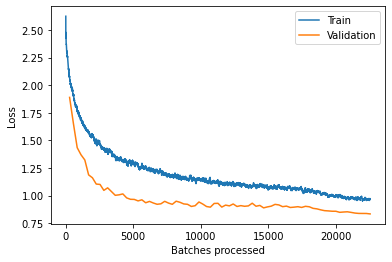

In [61]:
learn.recorder.plot_losses()

In [0]:
for _ in range(3):
    learn = get_learn(model=model, size=128, bs=32, mixup=0)
    learn.fit_fc(5, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.902802,1.813646,0.406719,0.886994,01:48
1,1.685970,1.553457,0.537032,0.928735,01:48
2,1.494283,1.428232,0.605498,0.944261,01:47
3,1.375602,1.260342,0.682871,0.955459,01:47
4,1.173522,1.112120,0.753627,0.970985,01:49


data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.883435,1.821366,0.416645,0.876050,01:48
1,1.636686,1.559664,0.541868,0.924408,01:48
2,1.481322,1.386785,0.622805,0.946551,01:48
3,1.351673,1.243179,0.689234,0.960041,01:48
4,1.138180,1.096480,0.758463,0.973530,01:48


data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.874111,1.813027,0.425554,0.892594,01:48
1,1.621625,1.545134,0.546449,0.925935,01:48
2,1.462013,1.387566,0.622805,0.942988,01:49
3,1.322632,1.246927,0.690252,0.959532,01:49
4,1.146231,1.085694,0.760499,0.975566,01:49


In [0]:
for name, param in learn.model.body.named_parameters():
    if 'ConvTwist' in name:
        print(name, param.size())

l_0.bl_0.convs.conv_1.ConvTwist.conv.weight torch.Size([64, 8, 3, 3])
l_0.bl_0.convs.conv_1.ConvTwist.conv_x.weight torch.Size([64, 8, 3, 3])
l_0.bl_0.convs.conv_1.ConvTwist.conv_y.weight torch.Size([64, 8, 3, 3])
l_0.bl_1.convs.conv_1.ConvTwist.conv.weight torch.Size([64, 8, 3, 3])
l_0.bl_1.convs.conv_1.ConvTwist.conv_x.weight torch.Size([64, 8, 3, 3])
l_0.bl_1.convs.conv_1.ConvTwist.conv_y.weight torch.Size([64, 8, 3, 3])
l_0.bl_2.convs.conv_1.ConvTwist.conv.weight torch.Size([64, 8, 3, 3])
l_0.bl_2.convs.conv_1.ConvTwist.conv_x.weight torch.Size([64, 8, 3, 3])
l_0.bl_2.convs.conv_1.ConvTwist.conv_y.weight torch.Size([64, 8, 3, 3])
l_1.bl_0.convs.conv_1.ConvTwist.conv.weight torch.Size([128, 8, 3, 3])
l_1.bl_0.convs.conv_1.ConvTwist.conv_x.weight torch.Size([128, 8, 3, 3])
l_1.bl_0.convs.conv_1.ConvTwist.conv_y.weight torch.Size([128, 8, 3, 3])
l_1.bl_1.convs.conv_1.ConvTwist.conv.weight torch.Size([128, 8, 3, 3])
l_1.bl_1.convs.conv_1.ConvTwist.conv_x.weight torch.Size([128, 8, 3, 3

In [0]:
for i in range(80):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.3866123557090759
epoch 1 0.4499872624874115
epoch 2 0.5008907914161682
epoch 3 0.5970984697341919
epoch 4 0.6304402947425842
epoch 5 0.6688724756240845
epoch 6 0.6986510753631592
epoch 7 0.7327564358711243
epoch 8 0.7401374578475952
epoch 9 0.768134355545044
epoch 10 0.7643166184425354
epoch 11 0.7688979506492615
epoch 12 0.7673708200454712
epoch 13 0.7956222891807556
epoch 14 0.7930771112442017
epoch 15 0.814202070236206
epoch 16 0.8058030009269714
epoch 17 0.8180198669433594
epoch 18 0.8024942874908447
epoch 19 0.8170017600059509
epoch 20 0.8088572025299072
epoch 21 0.8198014497756958
epoch 22 0.8213285803794861
epoch 23 0.8187834024429321
epoch 24 0.8282005786895752
epoch 25 0.828964114189148
epoch 26 0.8261644244194031
epoch 27 0.8139475584030151
epoch 28 0.836090624332428
epoch 29 0.8332909345626831
epoch 30 0.8340544700622559
epoch 31 0.8345634937286377
epoch 32 0.833545446395874
epoch 33 0.8368541598320007
epoch 34 0.8381267786026001
epoch 35 0.8294731378555298
epoch 3

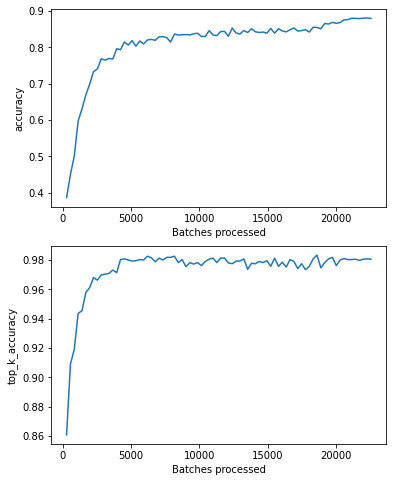

In [0]:
learn.recorder.plot_metrics()